# [Jabama](https://www.jabama.com/) website data analysis (Hotels part)

I will analyze data generated from *Jabama.com*. As we can see from hotels scrap notebook, *Data.csv* consists of 9 features. Running *HotelsScrap.ipynb* notebook is necessary for this notebook.

## Import libraries
*Numpy* and *pandas* are needed as basic libraries of data analysis. *Seaborn* and *matplotlib* are needed for data visualization. *IPython.display* is used to shwo several output in 1 cell.

Due to the site local language, I need *unidecode* library for decoding Farsi characters. *bidi* and *arabic_reshaper* are also needed for writing Farsi characters in figures.

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

# !pip install Unidecode
from unidecode import unidecode

# !pip install arabic-reshaper
# !pip install python-bidi
from bidi.algorithm import get_display
from arabic_reshaper import reshape

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## Load data
The input data is in *Data.csv*. I load it with *utf-8* encoding. Due to the way I searched the site for hotels, some duplicated rows of data is generated, so I remove duplicates right after loading data. We can see the shape and sample rows of dataframe.

The whole site has **937** records for the hotels, but many of them (contains **581**), has invalid data. For example, many have not *price* or the *stars* are not a valid number between 1 to 7. Therefore, I deleted the invalid records and the final dataset contains **365** records.

In [75]:
df = pd.read_csv('Data.csv', encoding="utf-8")  
df.drop_duplicates(subset =None, keep = 'first', inplace = True)
df.shape

(356, 9)

If you are using *Google Colab*, you will need to run the cell bellow.

In [76]:
# from google.colab import files
# import pandas as pd
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.StringIO(uploaded['Data.csv'].decode('utf-8')))
# df.drop_duplicates(subset =None, keep = 'first', inplace = True)
# df.shape

In [77]:
df.head()

,code,kind,name,price,comment,score,province,city,star
0,ardebil-saray,hotel,هتل سارای,۴۲۰۰۰۰,(۱),۱.۸,اردبیل,اردبیل,(۳ ستاره)
1,ardebil-darya,hotel,هتل دریا,۳۰۴۰۰۰,(۸),۲.۵,اردبیل,اردبیل,(۳ ستاره)
2,ardabil-sabalan,hotel,هتل سبلان,۳۰۳۰۰۰,(۷),۳.۱,اردبیل,اردبیل,(۳ ستاره)
3,sarein-koorosh,hotel,هتل کوروش,۳۲۵۰۰۰,(۲),۲.۳,اردبیل,سرعین,(۳ ستاره)
4,saryen-ershad,hotel,هتل بوستان,۳۵۰۰۰۰,(۸),۳,اردبیل,سرعین,(۴ ستاره)


## Cleaning data
Because of the our data structures and *Farsi* characters, I have some preprocesses do for cleaning data. The numeric data is located inside of a string phrase. For example the htel *stars* is loctated inside of such a phrase : *(۴ ستاره)*. 

I need to extract the numeric data from text and decode it, to obtain a usable data. Many features have this situation, some of them only need decoding, some of them need decoding and extraction. Therefore preparing data is a hard and time consuming process in this notebook. In addition to extraction and decoding, I set the type of all features so that I do not have any feature with object data type.

For this purpose, I will add some *temp* columns to dataframe for data separation. When this process ends, I remove those temparory columns.

In [78]:
# int columns
df['price'] = pd.to_numeric(df.price.apply(unidecode), errors='coerce').replace(np.nan, 0).astype(int)

# float column
df[['score','temp']] = df['score'].str.split('.',expand=True)
df['score'] = df['score'].replace(np.nan, '۰')
df['temp'] = df['temp'].replace(np.nan, '۰').astype(float)
df['score'] = pd.to_numeric(df.score.apply(unidecode), errors='coerce').astype(float)
df['score'] = df['score'] + (df['temp'] * 0.1)

# string columns
df['star'] = df['star'].replace({'ستاره':''}, regex=True)
df[['temp1','star']] = df['star'].str.split('(',expand=True)
df['star'] = df['star'].replace({'\)': ''}, regex=True)
df['star'] = pd.to_numeric(df.star.apply(unidecode), errors='coerce').replace(np.nan, 0).astype(int)

df[['temp1','comment']] = df['comment'].str.split('(',expand=True)
df['comment'] = df['comment'].replace({'\)': ''}, regex=True)
df['comment'] = df['comment'].fillna('').astype(pd.StringDtype())
df['comment'] = pd.to_numeric(df.comment.apply(unidecode), errors='coerce').replace(np.nan, 0).astype(int)

df['code'] = df['code'].fillna('').astype(pd.StringDtype())
df['kind'] = df['kind'].fillna('').astype(pd.StringDtype())
df['name'] = df['name'].fillna('').astype(pd.StringDtype())
df['province'] = df['province'].fillna('').astype(pd.StringDtype())
df['city'] = df['city'].fillna('').astype(pd.StringDtype())

# drop temp column
df.drop('temp1', inplace=True, axis=1)
df.drop('temp', inplace=True, axis=1)

You can notice that data is extracted correctly and all 9 columns have correct, unique, non-null and decoded data. The head of data and column information are shown bellow.

In [79]:
df.head()

,code,kind,name,price,comment,score,province,city,star
0,ardebil-saray,hotel,هتل سارای,420000,1,1.8,اردبیل,اردبیل,3
1,ardebil-darya,hotel,هتل دریا,304000,8,2.5,اردبیل,اردبیل,3
2,ardabil-sabalan,hotel,هتل سبلان,303000,7,3.1,اردبیل,اردبیل,3
3,sarein-koorosh,hotel,هتل کوروش,325000,2,2.3,اردبیل,سرعین,3
4,saryen-ershad,hotel,هتل بوستان,350000,8,3.0,اردبیل,سرعین,4


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 399
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   code      356 non-null    string 
 1   kind      356 non-null    string 
 2   name      356 non-null    string 
 3   price     356 non-null    int32  
 4   comment   356 non-null    int32  
 5   score     356 non-null    float64
 6   province  356 non-null    string 
 7   city      356 non-null    string 
 8   star      356 non-null    int32  
dtypes: float64(1), int32(3), string(5)
memory usage: 23.6 KB


In [81]:
df.groupby('province')[['price', 'score', 'star']].agg([np.min ,np.max, np.mean, np.var, 'count'])

price                                             score  \
                       amin     amax           mean           var count  amin   
province                                                                        
آذربایجان شرقی       230000   950000  443420.000000  4.673359e+10    20   0.0   
آذربایجان غربی       578000  1492000  900000.000000  2.635240e+11     3   3.6   
اردبیل               156000   614200  379830.769231  1.585672e+10    13   1.8   
اصفهان               125000  1220000  469250.000000  4.450368e+10    36   0.0   
البرز                373000   398000  385500.000000  3.125000e+08     2   0.0   
ایلام                266000   360000  313000.000000  4.418000e+09     2   2.2   
بوشهر                244000   410000  327000.000000  1.377800e+10     2   2.1   
تهران                220000   940000  508030.188679  2.969298e+10    53   0.0   
خراسان رضوی           98000  1605000  391727.083333  8.158203e+10    48   0.0   
زنجان                500000   807000  614000.000000  2.824300e+10     3   3.3   
سمنان                333000   749000  541000.000000  8.652800e+10     2   1.0   
فارس                 110000   994000  444666.666667  5.190099e+10    30   0.0   
قزوین                209000   675000  412800.000000  1.737763e+10    12   0.0   
قم                   300000   625000  426666.666667  3.025833e+10     3   3.0   
مازندران             240000  1270000  566360.000000  8.009249e+10    25   0.0   
مرکزی                494000   602000  548000.000000  5.832000e+09     2   3.3   
هرمزگان              114000  2760000  536161.290323  2.702710e+11    31   0.0   
همدان                294000   510000  387714.285714  4.096571e+09     7   2.8   
کردستان              173000   545000  357666.666667  1.877575e+10     9   0.0   
کرمان                341000   705000  520157.142857  2.072084e+10     7   0.0   
کرمانشاه             295000   567000  454400.000000  1.615430e+10     5   2.2   
کهگیلویه و بویراحمد  375700   375700  375700.000000           NaN     1   0.0   
گلستان                    0   564000  347844.444444  2.854222e+10     9   0.0   
گیلان                188000   650000  429333.333333  2.321170e+10    12   2.9   
یزد                  220000   740000  470173.684211  2.353783e+10    19   1.7   

                                                   star                 \
                    amax      mean       var count amin amax      mean   
province                                                                 
آذربایجان شرقی       4.5  3.020000  2.571158    20    1    5  3.100000   
آذربایجان غربی       4.0  3.800000  0.040000     3    4    5  4.333333   
اردبیل               4.1  3.076923  0.388590    13    1    4  3.000000   
اصفهان               4.5  3.038889  1.800730    36    1    5  2.944444   
البرز                3.4  1.700000  5.780000     2    2    2  2.000000   
ایلام                2.3  2.250000  0.005000     2    2    3  2.500000   
بوشهر                3.3  2.700000  0.720000     2    2    3  2.500000   
تهران                5.0  3.458491  1.170936    53    1    5  3.396226   
خراسان رضوی          4.9  3.458333  2.003333    48    1    5  3.250000   
زنجان                3.5  3.400000  0.010000     3    2    4  3.000000   
سمنان                3.5  2.250000  3.125000     2    4    5  4.500000   
فارس                 4.4  3.470000  1.135966    30    1    5  3.233333   
قزوین                4.5  2.933333  2.595152    12    1    4  2.250000   
قم                   3.5  3.300000  0.070000     3    3    4  3.666667   
مازندران             5.0  2.728000  2.131267    25    1    5  3.000000   
مرکزی                3.9  3.600000  0.180000     2    4    5  4.500000   
هرمزگان              4.4  2.925806  1.094645    31    2    5  3.354839   
همدان                4.4  3.685714  0.301429     7    2    4  3.714286   
کردستان              3.8  2.744444  1.517778     9    2    5  3.333333   
کرمان                4.1  2.771429  1.952381     7    2    4  3.142857   
کرمانشاه             4.3  3.520000  0.647000     5 

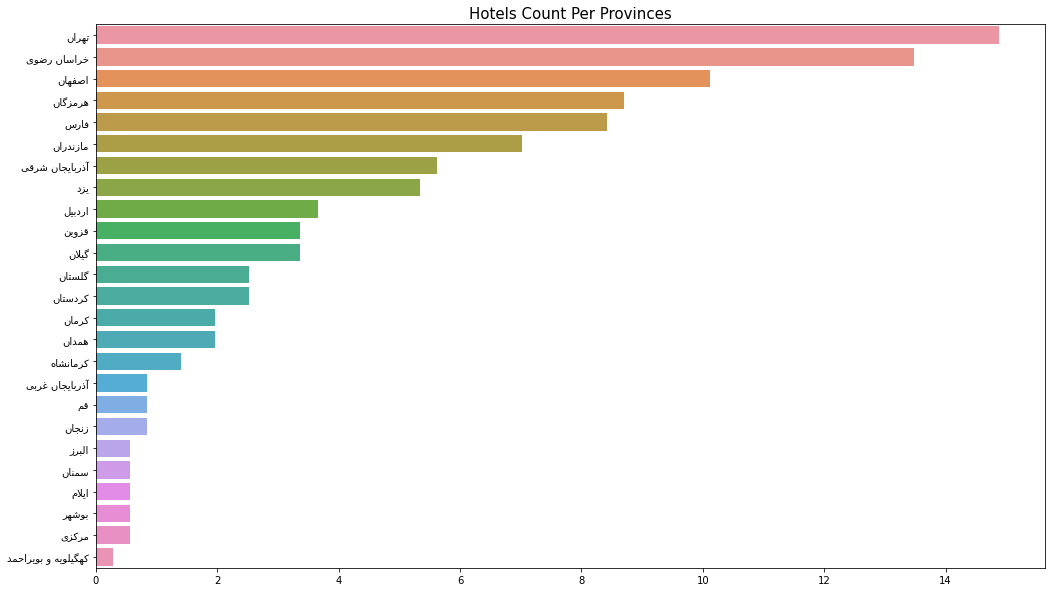

In [82]:
plt.figure(figsize = (17, 10))

x_labels = df['province'].value_counts(sort = True , normalize = True).index.tolist()
y_labels = df['province'].value_counts(sort = True , normalize = True).tolist()
y_labels = [element * 100 for element in y_labels]
persian_labels = [get_display(reshape(label)) for label in x_labels]
data = {'province':persian_labels, 'percentage':y_labels, 'province_name':x_labels}
df_temp_province = pd.DataFrame(data)

category_plot = sns.barplot(y="province", x="percentage" , data=df_temp_province)
plt.xlabel('')
plt.ylabel('')
plt.title(get_display(reshape('Hotels Count Per Provinces')), fontsize = 15)
plt.show()


In [83]:
df_temp_province[['province_name','percentage']].head(6)

,province_name,percentage
0,تهران,14.887640
1,خراسان رضوی,13.483146
2,اصفهان,10.112360
3,هرمزگان,8.707865
4,فارس,8.426966
5,مازندران,7.022472


C:\Users\a.alimadadi\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


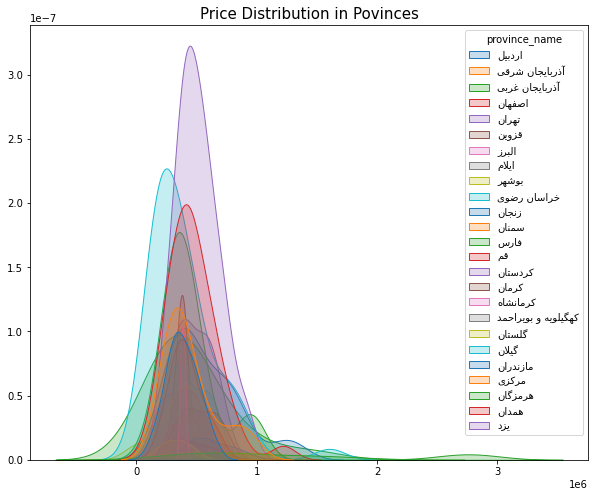

In [84]:
plt.figure(figsize= (10, 8))
df_temp_province = df
df_temp_province['province_name'] = [get_display(reshape(label)) for label in df['province']]
df_temp_province.head()
sns.kdeplot(x = "price", hue = "province_name", fill= True,data = df_temp_province, palette= "tab10")
plt.title(get_display(reshape('Price Distribution in Povinces')), fontsize = 15)
plt.ylabel('')
plt.xlabel('')
plt.show()

The most important features affecting the hotels' *Price*, are *Province* and *Stars*. So I make *dummies* based on *Province* and this will be my final dataset. The final dataset will have *365* rows and *34* columns.

In [85]:
df_temp = pd.get_dummies(df, columns=["province"])
df_temp.head()


,code,kind,name,price,comment,score,city,star,province_name,province_آذربایجان شرقی,...,province_مرکزی,province_هرمزگان,province_همدان,province_کردستان,province_کرمان,province_کرمانشاه,province_کهگیلویه و بویراحمد,province_گلستان,province_گیلان,province_یزد
0,ardebil-saray,hotel,هتل سارای,420000,1,1.8,اردبیل,3,ﻞﯿﺑﺩﺭﺍ,0,...,0,0,0,0,0,0,0,0,0,0
1,ardebil-darya,hotel,هتل دریا,304000,8,2.5,اردبیل,3,ﻞﯿﺑﺩﺭﺍ,0,...,0,0,0,0,0,0,0,0,0,0
2,ardabil-sabalan,hotel,هتل سبلان,303000,7,3.1,اردبیل,3,ﻞﯿﺑﺩﺭﺍ,0,...,0,0,0,0,0,0,0,0,0,0
3,sarein-koorosh,hotel,هتل کوروش,325000,2,2.3,سرعین,3,ﻞﯿﺑﺩﺭﺍ,0,...,0,0,0,0,0,0,0,0,0,0
4,saryen-ershad,hotel,هتل بوستان,350000,8,3.0,سرعین,4,ﻞﯿﺑﺩﺭﺍ,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# df_model = df_temp[['price','star']]
df_model = df_temp
df_model.drop(['code','kind','name','comment','score','city','province_name'], inplace=True, axis=1)
df_model.head()

df_model = df_model.sample(frac=1,random_state = 10).reset_index(drop=True)

In [87]:
df_model.head()

,price,star,province_آذربایجان شرقی,province_آذربایجان غربی,province_اردبیل,province_اصفهان,province_البرز,province_ایلام,province_بوشهر,province_تهران,...,province_مرکزی,province_هرمزگان,province_همدان,province_کردستان,province_کرمان,province_کرمانشاه,province_کهگیلویه و بویراحمد,province_گلستان,province_گیلان,province_یزد
0,585000,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,425000,4,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,525000,4,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,447000,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,405000,5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


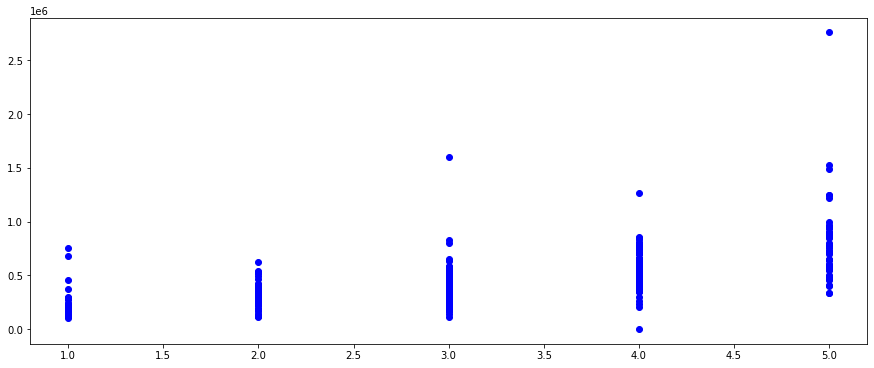

In [88]:
plt.figure(figsize= (15, 6))
plt.scatter(df_model.star, df_model.price, color='blue')
plt.show()

In [89]:
temp_data = df_model.to_numpy()
X = temp_data[:,1:]
y = temp_data[:,0]

In [90]:
X.shape

(356, 26)

In [91]:
y.shape

(356,)

In [92]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [94]:
for degree in [1,3,5]:
    model = PolynomialRegression(degree)
    model.fit(X, y)
#     .predict(X_test)
    print(degree,model.score(X,y))


1 0.42296033728023297
3 0.634095370304647
5 0.6553507401623856


In [ ]:
plt.figure(figsize= (15, 6))

from sklearn.model_selection import validation_curve
degree = [1,3,5]

train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

# print(train_score)
# print(val_score)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[1, 3, 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=10,train_size=0.8)

for degree in [1,5,7,10]:
    model = PolynomialRegression(degree)
    model.fit(X1, y1)
    print(degree,model.score(X2,y2))